# Analysis for Research Question 2
This notebook will be focused on analysing the data scraped for research question 2: **How Important is Managing Your Economy?**

Intially, I will look into how the amount of low buy rounds (eco and force rounds) impacts the win rate of a match. I will then move on to other factors like pistol rounds (the first round of each half), the teams best at adapting, and if low buy round success correlates to tournament success.

To begin, import the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit

Next, load the scraped data into DataFrames.

In [2]:
# Team economics data scraped from DreamTeam.gg
dfEconomics = pd.read_csv("ECONOMICS_STATS_TEAM.csv")
dfHLTVStats = pd.read_csv("MAJOR_MATCH_STATS.csv", index_col=0)
dfHLTVStatsClean = pd.read_csv("HLTVMATCHES_CLEAN.csv", index_col=0)

A new DataFrame is created which contains just info on who won each match. This will be used helpful later in merging.

In [3]:
# Only keep Match ID and Match Winner
dfMatchWinner = dfEconomics[["Match ID", "Match Winner"]]

# Only keep one instance per match
dfMatchWinner = dfMatchWinner.drop_duplicates()
dfMatchWinner

,Match ID,Match Winner
0,17523,Ninjas in Pyjamas
46,17524,Epsilon eSports
80,17525,HellRaisers
120,17526,Team LDLC.com
156,17527,Natus Vincere
200,17528,Copenhagen Wolves
242,17529,Virtus.Pro
288,17530,Fnatic
334,17532,Team Dignitas
384,17533,Cloud9


Functions are written for code that will be reusued multiple times.

In [4]:
# Functions

# Get a count of the specified round type for each game
def get_round_per_match(df):
    # Group by Match ID and Team and count rounds
    dfRoundCount = df.groupby(["Match ID", "Team"])[["Round"]].count()
    # Remove multi-level index
    dfRoundCount = dfRoundCount.reset_index(level=["Team"])
    # Merge with dfMatchWinner to show which team one each match
    dfRoundCount = pd.merge(dfRoundCount, dfMatchWinner, on=["Match ID"])
    # Add boolean column to tell if team won match or not
    dfRoundCount["Team Won"] = (dfRoundCount["Team"] == dfRoundCount["Match Winner"])
    
    return dfRoundCount
        
# Get the wins of the specified round type for each game
def get_win_rate(df):
    # Call previous function
    dfRoundCount = get_round_per_match(df)
    
    # Get mean win rate
    dfWinMean = dfRoundCount.groupby("Round")[["Team Won"]].mean()
    # Remove multi-level index
    dfWinMean = dfWinMean.reset_index(level=["Round"])
    
    # Count how many times x amount of rounds occurs
    dfCount = dfRoundCount.groupby("Round")["Match ID"].count()
    # Remove multi-level index
    dfCount = dfCount.reset_index(level=["Round"])
    
    # Merge two dataframes
    dfWinRate = pd.merge(dfWinMean, dfCount, on=["Round"])
    # Only include if more than 10 occurences
    dfWinRate = dfWinRate[dfWinRate["Match ID"] > 10]
    # Drop Match ID column
    dfWinRate = dfWinRate.drop(["Match ID"], axis=1)
    
    return dfWinRate

# Calculate win rate by team
def get_team_win_rate(df):
    # Calculate win rate by team
    dfMean = df.groupby("Team")[["Won Round"]].mean()
    
    # Calculate occurences
    dfCount = df.groupby("Team")[["Round"]].count()
    
    # Merge
    dfWinRate = pd.merge(dfMean, dfCount, on=["Team"])
    
    return dfWinRate

# Get top 3 and bottom 3 at round success
def get_best_and_worst(df):
    # Get win rate by team
    dfWinRate = get_team_win_rate(df)
    
    # Only include teams with more than 10 rounds
    dfWinRate = dfWinRate[dfWinRate["Round"] > 10]
    
    # Sort values
    dfWinRate = dfWinRate.sort_values(by=["Won Round"])
    
    # Get 3 Best and 3 Worst (BaW)
    dfBaW = dfWinRate.head(3)
    dfBaW = dfBaW.append(dfWinRate.tail(3))
    
    return dfBaW

# Calculate the mean success rate
def get_team_mean(df):
    # Get win rate by team
    dfWinRate = get_team_win_rate(df)
    
    # Calculate mean
    mean = dfWinRate["Won Round"].mean()
    
    return mean

## How Important is Managing Your Economy?
To analyse this question, I will plot a line graph showing how win rate of a match changes as the amount of low buy rounds a team has in one game increases.

First, only take force and eco rounds from the original dataset.

In [5]:
# Eco Rounds
dfEcoRounds = dfEconomics[dfEconomics["Round Type"] == "eco"]
dfEcoRounds

,Match ID,Round,Team,Side,Round Type,Winner,Winner Side,Match Winner,Won Round,Won Match
3,17523,2,Ninjas in Pyjamas,terrorist,eco,MTS GameGod Wolf,ct,Ninjas in Pyjamas,False,True
6,17523,4,MTS GameGod Wolf,ct,eco,Ninjas in Pyjamas,terrorist,Ninjas in Pyjamas,False,False
12,17523,7,MTS GameGod Wolf,ct,eco,MTS GameGod Wolf,ct,Ninjas in Pyjamas,True,False
22,17523,12,MTS GameGod Wolf,ct,eco,Ninjas in Pyjamas,terrorist,Ninjas in Pyjamas,False,False
33,17523,17,Ninjas in Pyjamas,ct,eco,MTS GameGod Wolf,terrorist,Ninjas in Pyjamas,False,True
35,17523,18,Ninjas in Pyjamas,ct,eco,Ninjas in Pyjamas,ct,Ninjas in Pyjamas,True,True
36,17523,19,MTS GameGod Wolf,terrorist,eco,MTS GameGod Wolf,terrorist,Ninjas in Pyjamas,True,False
51,17524,3,HellRaisers,terrorist,eco,Epsilon eSports,ct,Epsilon eSports,False,False
63,17524,9,HellRaisers,terrorist,eco,Epsilon eSports,ct,Epsilon eSports,False,False
67,17524,11,HellRaisers,terrorist,eco,Epsilon eSports,ct,Epsilon eSports,False,False


In [6]:
# Force Rounds
dfForceRounds = dfEconomics[dfEconomics["Round Type"] == "force"]
dfForceRounds

,Match ID,Round,Team,Side,Round Type,Winner,Winner Side,Match Winner,Won Round,Won Match
8,17523,5,MTS GameGod Wolf,ct,force,Ninjas in Pyjamas,terrorist,Ninjas in Pyjamas,False,False
16,17523,9,MTS GameGod Wolf,ct,force,Ninjas in Pyjamas,terrorist,Ninjas in Pyjamas,False,False
26,17523,14,MTS GameGod Wolf,ct,force,Ninjas in Pyjamas,terrorist,Ninjas in Pyjamas,False,False
40,17523,21,MTS GameGod Wolf,terrorist,force,Ninjas in Pyjamas,ct,Ninjas in Pyjamas,False,False
44,17523,23,MTS GameGod Wolf,terrorist,force,Ninjas in Pyjamas,ct,Ninjas in Pyjamas,False,False
49,17524,2,HellRaisers,terrorist,force,Epsilon eSports,ct,Epsilon eSports,False,False
55,17524,5,HellRaisers,terrorist,force,Epsilon eSports,ct,Epsilon eSports,False,False
79,17524,17,HellRaisers,ct,force,Epsilon eSports,terrorist,Epsilon eSports,False,False
82,17525,2,HellRaisers,ct,force,MTS GameGod Wolf,terrorist,HellRaisers,False,True
88,17525,5,HellRaisers,ct,force,HellRaisers,ct,HellRaisers,True,True


Next, use previously defined functions to calculate the win rates of teams who have X amount of these rounds.

In [7]:
# Get the win rate after X amount of eco rounds
dfEcoWinRate = get_win_rate(dfEcoRounds)
dfEcoWinRate 

,Round,Team Won
0,1,0.510753
1,2,0.453125
2,3,0.241758
3,4,0.100000
4,5,0.071429


In [8]:
# Get the win rate after X amount of force rounds
dfForceWinRate = get_win_rate(dfForceRounds)
dfForceWinRate 

,Round,Team Won
0,1,0.880597
1,2,0.750000
2,3,0.509434
3,4,0.520408
4,5,0.319149
5,6,0.229730
6,7,0.222222
7,8,0.083333


Finally, using matplotlib, plot the two win rate DataFrames on the same line graph to show how the win rates differ.

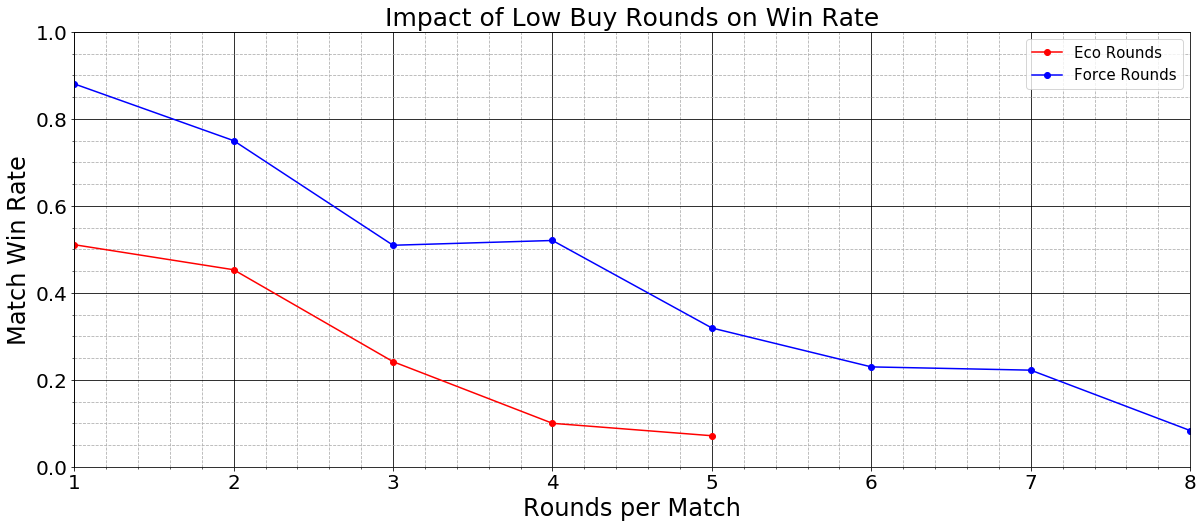

In [9]:
# Plotting two seperate DataFrames, so use subplots
fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

# Plot intial graphs
# Plot Eco Win Rate, with red
ax.plot(dfEcoWinRate["Round"], dfEcoWinRate["Team Won"], c='r', marker="o", label="Eco Rounds")
# Plot Force Win Rate, with blue
ax.plot(dfForceWinRate["Round"], dfForceWinRate["Team Won"], c='b', marker="o", label="Force Rounds")

# Add labels
ax.set_title("Impact of Low Buy Rounds on Win Rate", fontsize=25)
ax.set_ylabel("Match Win Rate", fontsize = 24)
ax.set_xlabel("Rounds per Match", fontsize = 24)

# Add params, so that label size can be increased
ax.tick_params(labelsize=20)

# Set axis limits
ax.set_ylim(0,1)
ax.set_xlim(1,8)

# Add gridlines
ax.minorticks_on()
ax.grid(which="minor", zorder=-2, linestyle="--")
ax.grid(which="major", color="black", zorder=-1, linestyle="-")

# Add legend
ax.legend(fontsize=15)

As we can see from the graph, a teams inability to manage their economy can have catastrophic results. As the amount of low buy rounds per match increases, a team's win rate decreases. The fact that there are more force rounds than eco rounds could be due to a number of factors. For instance, a team would never take an eco round on the last round of the first half, because they're economy would be reset in the next half. Or a team might be trailing by a large deficit and so they cannot afford to take the sacrifice of an eco round.

After this intial analysis, I know want to look at which teams are the best and worst at winning these low buy rounds.

Using previously defined functions, find the three best and three worst teams in eco and force rounds.

In [10]:
dfEcoBaW = get_best_and_worst(dfEcoRounds)
dfEcoBaW

,Won Round,Round
Team,,
Astralis,0.000000,39
Titan,0.000000,19
Team Liquid,0.000000,38
Copenhagen Wolves,0.142857,14
SK Gaming,0.153846,13
Team LDLC.com,0.230769,26


In [11]:
dfForceBaW = get_best_and_worst(dfForceRounds)
dfForceBaW

,Won Round,Round
Team,,
Splyce,0.066667,15
Vox Eminor,0.105263,19
BIG,0.111111,18
SK Gaming,0.358974,78
Gambit Gaming,0.378641,103
Immortals,0.458333,24


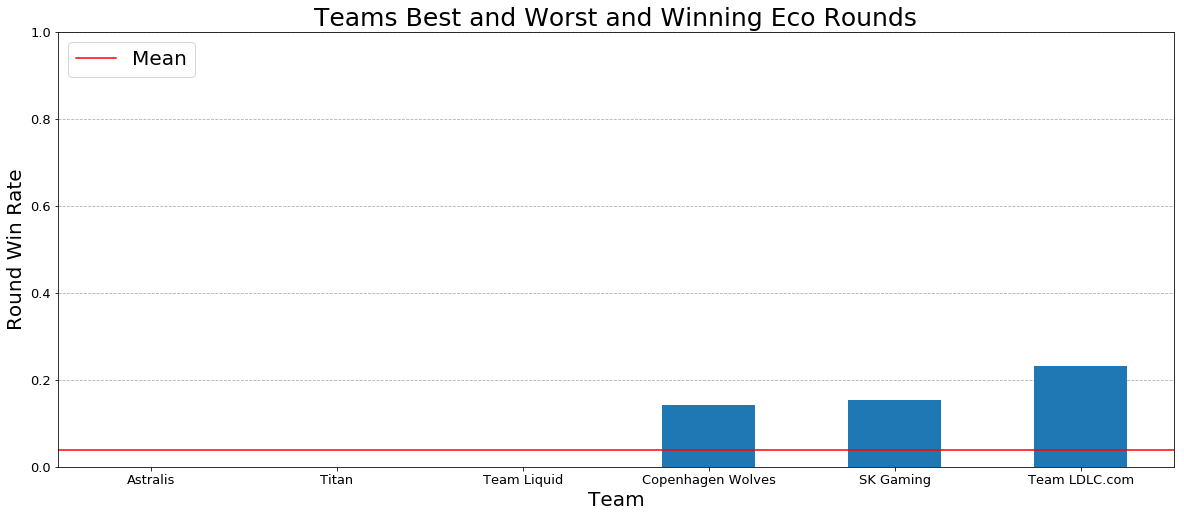

In [12]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfEcoBaW["Won Round"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=get_team_mean(dfEcoRounds), color="r", label="Mean")

# Add labels and titles
ax.set_title("Teams Best and Worst and Winning Eco Rounds", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 20)
ax.set_xlabel("Team", fontsize = 20)

# Set axis and tick params
ax.set_ylim(0,1)
ax.tick_params(rotation=0)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize = 20)

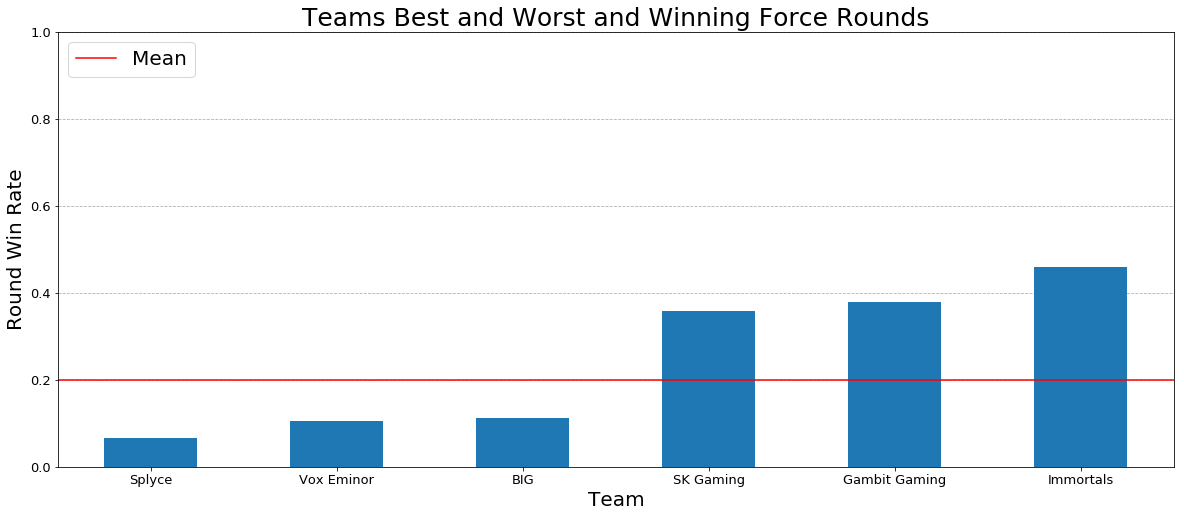

In [13]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfForceBaW["Won Round"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=get_team_mean(dfForceRounds), color="r", label="Mean")

# Add labels and titles
ax.set_title("Teams Best and Worst and Winning Force Rounds", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 20)
ax.set_xlabel("Team", fontsize = 20)

# Set axis and tick params
ax.set_ylim(0,1)
ax.tick_params(rotation=0)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize = 20)

The bottom three teams in the eco round graph have all have a win rate of 0, while Team LDLC.com have a win rate of over 0.2, way above the mean.

No team has a win rate in the force buy graph, however we see five new teams. SK Gaminga are the only team from the previous graph, again having the third best win rate and nearly double that of the mean win rate. SK Gaming clearly are one of the strongest teams when looking at all low buy rounds.

## Impact of Winning Pistol Rounds on Match Win Rate
Pistol rounds are the first rounds of each half. Each player starts off with $800, which is enough for kevlar, or an upgraded pistol and some utility (e.g. smoke grenade or a flashbang). The winner of these rounds is able to get a headstart on managing their economy as the team that loses usually has to take a force buy or an eco into the next round, depending on the situation. For this reason I think it will be interesting to see how the overall win rates of matches are affected by these pistol rounds.

If I were to calculate the win rates by rounds won as I did previously, the result would be incorrect for teams who won one pistol round. It would show that teams who won one pistol round had a win rate of 0.5, because there are only two pistol rounds per game. So instead I will plot a scatter plot of teams pistol success against their overall win rate.

In [14]:
# Get pistol rounds only
dfPistolRounds = dfEconomics[dfEconomics["Round Type"] == "pistol"]
dfPistolRounds

,Match ID,Round,Team,Side,Round Type,Winner,Winner Side,Match Winner,Won Round,Won Match
0,17523,1,MTS GameGod Wolf,ct,pistol,MTS GameGod Wolf,ct,Ninjas in Pyjamas,True,False
1,17523,1,Ninjas in Pyjamas,terrorist,pistol,MTS GameGod Wolf,ct,Ninjas in Pyjamas,False,True
30,17523,16,MTS GameGod Wolf,terrorist,pistol,MTS GameGod Wolf,terrorist,Ninjas in Pyjamas,True,False
31,17523,16,Ninjas in Pyjamas,ct,pistol,MTS GameGod Wolf,terrorist,Ninjas in Pyjamas,False,True
46,17524,1,Epsilon eSports,ct,pistol,Epsilon eSports,ct,Epsilon eSports,True,True
47,17524,1,HellRaisers,terrorist,pistol,Epsilon eSports,ct,Epsilon eSports,False,False
76,17524,16,Epsilon eSports,terrorist,pistol,Epsilon eSports,terrorist,Epsilon eSports,True,True
77,17524,16,HellRaisers,ct,pistol,Epsilon eSports,terrorist,Epsilon eSports,False,False
80,17525,1,HellRaisers,ct,pistol,MTS GameGod Wolf,terrorist,HellRaisers,False,True
81,17525,1,MTS GameGod Wolf,terrorist,pistol,MTS GameGod Wolf,terrorist,HellRaisers,True,False


In [15]:
# Get pistol count
dfPistolCount = get_round_per_match(dfPistolRounds)

# Get pistol win rate per team per match
dfPistolMean = dfPistolRounds.groupby(["Match ID", "Team"])[["Won Round"]].mean()
dfPistolMean = dfPistolMean.reset_index(level=["Team"])

# Merge two DataFrames
dfPistolTeam = pd.merge(dfPistolCount, dfPistolMean, on=["Match ID", "Team"])
dfPistolTeam

,Match ID,Team,Round,Match Winner,Team Won,Won Round
0,17523,MTS GameGod Wolf,2,Ninjas in Pyjamas,False,1.0
1,17523,Ninjas in Pyjamas,2,Ninjas in Pyjamas,True,0.0
2,17524,Epsilon eSports,2,Epsilon eSports,True,1.0
3,17524,HellRaisers,2,Epsilon eSports,False,0.0
4,17525,HellRaisers,2,HellRaisers,True,0.5
5,17525,MTS GameGod Wolf,2,HellRaisers,False,0.5
6,17526,London Conspiracy,2,Team LDLC.com,False,0.0
7,17526,Team LDLC.com,2,Team LDLC.com,True,1.0
8,17527,Copenhagen Wolves,2,Natus Vincere,False,0.5
9,17527,Natus Vincere,2,Natus Vincere,True,0.5


In [16]:
# Calculate pistol win rate
dfPistolWinRate = dfPistolTeam.groupby("Won Round")[["Team Won"]].mean()
dfPistolWinRate = dfPistolWinRate.reset_index(level=["Won Round"])
dfPistolWinRate

,Won Round,Team Won
0,0.0,0.261628
1,0.5,0.500000
2,1.0,0.726744


Due to the fact that there are two, and only two pistols in a game, the win rate for teams who win one pistol will always be 0.5. To fix that, I would need the data of who won each half. As I do not possess that data, I will only be plotting the win rates of teams who won or lost both pistol rounds.

In [17]:
dfPistolWinRate = dfPistolWinRate[dfPistolWinRate["Won Round"] != 0.5]
dfPistolWinRate

,Won Round,Team Won
0,0.0,0.261628
2,1.0,0.726744


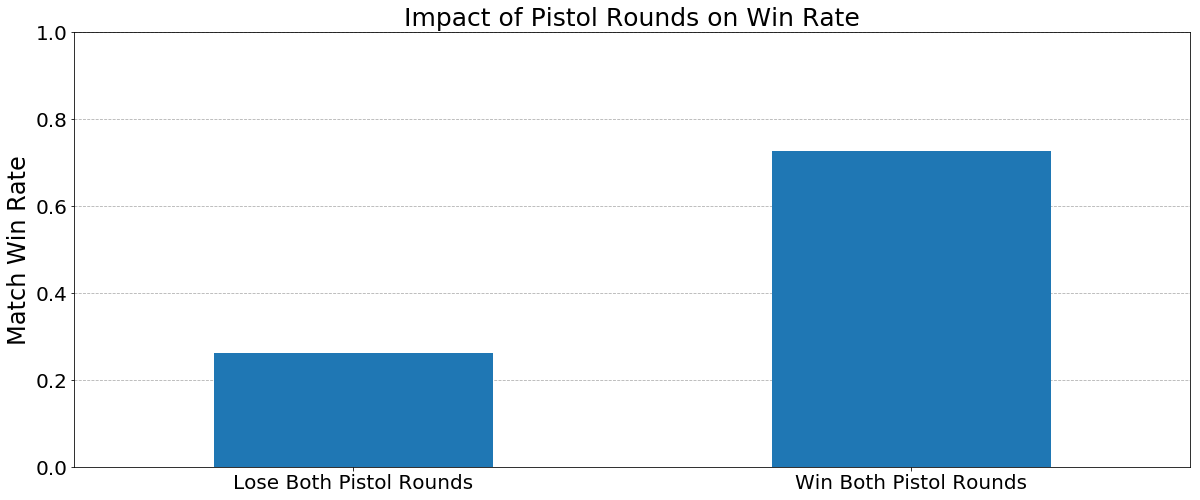

In [18]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
ax = dfPistolWinRate["Team Won"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0")

# Add labels and titles
ax.set_title("Impact of Pistol Rounds on Win Rate", fontsize=25)
ax.set_ylabel("Match Win Rate", fontsize = 24)
ax.set_xticklabels(["Lose Both Pistol Rounds", "Win Both Pistol Rounds"], fontsize=24)

# Rotate tick labels so they're easily legible
ax.tick_params(rotation=0, labelsize=20)

# Set ylim 
ax.set_ylim(0,1)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

As the graph clearly shows, teams that win both pistols are far more likely to win the match than their opponents. This shows just how important these rounds are to the rest of the match, which could be an indication that getting the early economy advantage is a huge help going forward.

Similar to the analysis of which teams are best and worst at converting low buy rounds, I now want to look at teams that are the best and worst at pistol rounds.

In [19]:
dfPistolBaW = get_best_and_worst(dfPistolRounds)
dfPistolBaW

,Won Round,Round
Team,,
Titan,0.227273,22
Luminosity Gaming,0.366667,30
Cloud9,0.384615,39
Immortals,0.642857,14
BIG,0.666667,12
Team SoloMid,0.800000,20


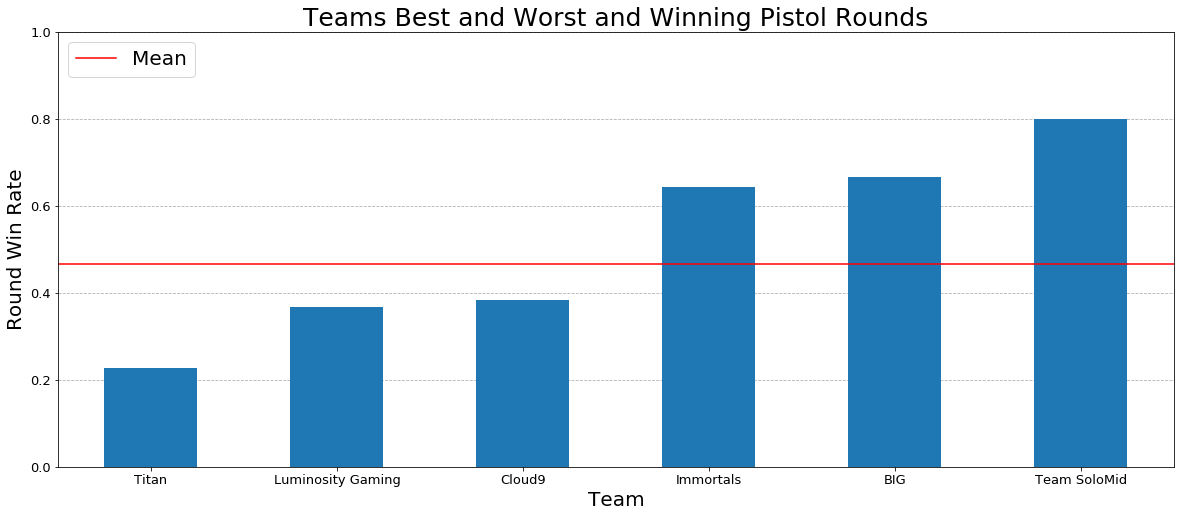

In [20]:
# Plot bar chart, zorder places the bars in front of the gridlines (default is 1)
# In this instance, the bar chart gives each bar a different colour by default
# To get the default blue colour, "C0" is used in the colour parameter
# _nolegend_ removes the bars from the legend
ax = dfPistolBaW["Won Round"].plot(kind="bar",figsize=(20, 8), fontsize=13, zorder=2, color="C0", label="_nolegend_")

# Add in the mean value
ax.axhline(y=get_team_mean(dfPistolRounds), color="r", label="Mean")

# Add labels and titles
ax.set_title("Teams Best and Worst and Winning Pistol Rounds", fontsize=25)
ax.set_ylabel("Round Win Rate", fontsize = 20)
ax.set_xlabel("Team", fontsize = 20)

# Set axis and tick params
ax.set_ylim(0,1)
ax.tick_params(rotation=0)

# Add gridlines
ax.grid(axis="y", linestyle="--")
ax.grid(axis="x", linestyle=" ")

# Add legend
ax.legend(loc="upper left", fontsize=20)

As we can see from the graph, Team SoloMid is the most successful team during pistol rounds, with a win rate of 0.8. Immortals appear once more, the team strongest at force rounds. Another team that appears again is Titan, the team joint worst at eco rounds.

## Does Low Buy Success Correlate to Tournament Success?
After showing how important it is to minimise low buy rounds, I now want to look into the relationship between success in these low buy rounds and success in a tournament. To do this I will take a tournament from my dataset, calculate the success on low buy rounds of the teams involved, and compare that to their final rankings in the tournament.

Due to the cleaning process removing matches, the tournament I select to use will be the one with the least misisng matches. So first, I need to compare two DataFrames to find the smallest difference.

In [21]:
dfHLTVStats.groupby("Event").count()

,Date,Team 1,Team 2,Map,Team 1 Rounds,Team 2 Rounds,Total Rounds,Winner,Team 1 FK,Team 2 FK,Team 1 Clutches,Team 2 Clutches,Team 1 Rating,Team 2 Rating
Event,,,,,,,,,,,,,,
DreamHack Open Cluj-Napoca 2015,42,42,42,42,42,42,42,42,42,42,42,42,42,42
DreamHack Winter 2013,40,40,40,40,40,40,40,40,40,40,40,40,40,40
DreamHack Winter 2014,36,36,36,36,36,36,36,36,36,36,36,36,36,36
ELEAGUE Major 2017,52,52,52,52,52,52,52,52,52,52,52,52,52,52
ELEAGUE Major 2018,50,50,50,50,50,50,50,50,50,50,50,50,50,50
EMS One Katowice 2014,37,37,37,37,37,37,37,37,37,37,37,37,37,37
ESL One Cologne 2014,38,38,38,38,38,38,38,38,38,38,38,38,38,38
ESL One Cologne 2015,36,36,36,36,36,36,36,36,36,36,36,36,36,36
ESL One Cologne 2016,42,42,42,42,42,42,42,42,42,42,42,42,42,42


In [22]:
dfHLTVStatsClean.groupby("Event").count()

,Match ID,Date,Team 1,Team 2,Map,Team 1 Rounds,Team 2 Rounds,Total Rounds,Winner,Team 1 FK,Team 2 FK,Team 1 Clutches,Team 2 Clutches,Team 1 Rating,Team 2 Rating
Event,,,,,,,,,,,,,,,
DreamHack Open Cluj-Napoca 2015,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
DreamHack Winter 2014,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
ELEAGUE Major 2017,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
ESL One Cologne 2014,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
ESL One Cologne 2015,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
ESL One Cologne 2016,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
ESL One Katowice 2015,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
FACEIT Major 2018,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
IEM Katowice 2019,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


As **ESL One Katowice 2015** has the smallest difference (3) in games remaining, it will be selected for this analysis.

In [23]:
dfHLTVStats[dfHLTVStats["Event"] == "ESL One Katowice 2015"]

,Event,Date,Team 1,Team 2,Map,Team 1 Rounds,Team 2 Rounds,Total Rounds,Winner,Team 1 FK,Team 2 FK,Team 1 Clutches,Team 2 Clutches,Team 1 Rating,Team 2 Rating
Match ID,,,,,,,,,,,,,,,
19275,ESL One Katowice 2015,2015-03-15 13:00:00,fnatic,NiP,Inferno,16,13,29,fnatic,14,15,1,2,1.02,0.91
19274,ESL One Katowice 2015,2015-03-15 13:00:00,fnatic,NiP,Cache,10,16,26,NiP,10,16,2,0,0.85,1.20
19273,ESL One Katowice 2015,2015-03-15 13:00:00,fnatic,NiP,Dust2,16,14,30,fnatic,17,13,2,1,1.01,0.93
19272,ESL One Katowice 2015,2015-03-14 20:00:00,Envy,NiP,Dust2,10,16,26,NiP,9,17,1,2,0.81,1.19
19271,ESL One Katowice 2015,2015-03-14 20:00:00,Envy,NiP,Cache,9,16,25,NiP,7,18,0,2,0.82,1.03
19270,ESL One Katowice 2015,2015-03-14 17:00:00,fnatic,Virtus.pro,Mirage,16,8,24,fnatic,15,9,3,1,1.11,0.79
19268,ESL One Katowice 2015,2015-03-14 17:00:00,fnatic,Virtus.pro,Cobblestone,19,17,36,fnatic,17,19,2,1,1.07,0.95
19267,ESL One Katowice 2015,2015-03-14 13:00:00,NiP,TSM,Nuke,16,12,28,NiP,19,9,1,0,1.08,0.88
19266,ESL One Katowice 2015,2015-03-14 13:00:00,NiP,TSM,Inferno,4,16,20,TSM,11,9,0,3,0.63,1.36


As seen from the DataFrame printed above, that means only matches with an ID between 19237 and 19275 are needed.

In [24]:
dfKato2015 = dfEconomics[(dfEconomics["Match ID"] >= 19237) & (dfEconomics["Match ID"] <= 19275)]
dfKato2015

,Match ID,Round,Team,Side,Round Type,Winner,Winner Side,Match Winner,Won Round,Won Match
3360,19237,1,Team EnVyUs,ct,pistol,Team EnVyUs,ct,Team EnVyUs,True,True
3361,19237,1,Titan,terrorist,pistol,Team EnVyUs,ct,Team EnVyUs,False,False
3362,19237,2,Team EnVyUs,ct,full,Titan,terrorist,Team EnVyUs,False,True
3363,19237,2,Titan,terrorist,force,Titan,terrorist,Team EnVyUs,True,False
3364,19237,3,Team EnVyUs,ct,force,Titan,terrorist,Team EnVyUs,False,True
3365,19237,3,Titan,terrorist,full,Titan,terrorist,Team EnVyUs,True,False
3366,19237,4,Team EnVyUs,ct,force,Team EnVyUs,ct,Team EnVyUs,True,True
3367,19237,4,Titan,terrorist,full,Team EnVyUs,ct,Team EnVyUs,False,False
3368,19237,5,Team EnVyUs,ct,full,Team EnVyUs,ct,Team EnVyUs,True,True
3369,19237,5,Titan,terrorist,full,Team EnVyUs,ct,Team EnVyUs,False,False


Find each team's win rate for each round variant.

In [25]:
dfKatoRoundType = dfKato2015.groupby(["Team", "Round Type"])[["Won Round"]].mean()
dfKatoRoundType

Won Round
Team                 Round Type           
3DMAX                eco          0.000000
                     force        0.000000
                     full         0.433333
                     pistol       0.500000
Cloud9               eco          0.500000
                     force        0.000000
                     full         0.500000
                     pistol       0.833333
Counter Logic Gaming eco          0.000000
                     force        0.076923
                     full         0.518519
                     pistol       0.285714
Flipsid3 Tactics     eco          0.000000
                     force        0.000000
                     full         0.157895
                     pistol       0.250000
Fnatic               eco          0.000000
                     force        0.400000
                     full         0.672956
                     pistol       0.500000
HellRaisers          eco          0.000000
                     force        0.000000
                     full         0.541667
                     pistol       0.500000
Keyd Stars           eco          0.000000
                     force        0.130435
                     full         0.500000
                     pistol       0.500000
LGB eSports          eco          0.250000
                     force        0.250000
...                                    ...
Natus Vincere        full         0.581633
                     pistol       0.583333
Ninjas in Pyjamas    eco          0.111111
                     force        0.181818
                     full         0.639053
                     pistol       0.588235
PENTA Sports         eco          0.200000
                     force        0.352941
                     full         0.555556
                     pistol       0.500000
TSM Kinguin          eco          0.000000
                     force        0.357143
                     full         0.648649
                     pistol       0.416667
Team EnVyUs          eco          0.000000
                     force        0.380952
                     full         0.600000
                     pistol       0.583333
Titan                eco          0.000000
                     force        0.363636
                     full         0.437500
                     pistol       0.000000
Virtus.Pro           eco          0.000000
                     force        0.318182
                     full         0.716667
                     pistol       0.416667
Vox Eminor           eco          0.000000
                     force        0.200000
                     full         0.405405
                     pistol       0.666667

[64 rows x 1 columns]

Unstack the DataFrame, which removes the multi-level index.

In [26]:
dfKatoLowBuy = dfKatoRoundType.unstack(level=-1)
dfKatoLowBuy

Won Round                              
Round Type                 eco     force      full    pistol
Team                                                        
3DMAX                 0.000000  0.000000  0.433333  0.500000
Cloud9                0.500000  0.000000  0.500000  0.833333
Counter Logic Gaming  0.000000  0.076923  0.518519  0.285714
Flipsid3 Tactics      0.000000  0.000000  0.157895  0.250000
Fnatic                0.000000  0.400000  0.672956  0.500000
HellRaisers           0.000000  0.000000  0.541667  0.500000
Keyd Stars            0.000000  0.130435  0.500000  0.500000
LGB eSports           0.250000  0.250000  0.441176  0.250000
Natus Vincere         0.000000  0.352941  0.581633  0.583333
Ninjas in Pyjamas     0.111111  0.181818  0.639053  0.588235
PENTA Sports          0.200000  0.352941  0.555556  0.500000
TSM Kinguin           0.000000  0.357143  0.648649  0.416667
Team EnVyUs           0.000000  0.380952  0.600000  0.583333
Titan                 0.000000  0.363636  0.437500  0.000000
Virtus.Pro            0.000000  0.318182  0.716667  0.416667
Vox Eminor            0.000000  0.200000  0.405405  0.666667

Drop the first level of columns so that the unnecessary "full" column can be dropped.

In [27]:
dfKatoLowBuy.columns = dfKatoLowBuy.columns.droplevel()
dfKatoLowBuy = dfKatoLowBuy.drop(["full"], axis=1)
dfKatoLowBuy

Round Type,eco,force,pistol
Team,,,
3DMAX,0.000000,0.000000,0.500000
Cloud9,0.500000,0.000000,0.833333
Counter Logic Gaming,0.000000,0.076923,0.285714
Flipsid3 Tactics,0.000000,0.000000,0.250000
Fnatic,0.000000,0.400000,0.500000
HellRaisers,0.000000,0.000000,0.500000
Keyd Stars,0.000000,0.130435,0.500000
LGB eSports,0.250000,0.250000,0.250000
Natus Vincere,0.000000,0.352941,0.583333


The teams' mean win rate of the three round types is calculated and added to a new column.

In [28]:
dfKatoLowBuy["Mean"] = dfKatoLowBuy.mean(axis=1)
dfKatoLowBuy

Round Type,eco,force,pistol,Mean
Team,,,,
3DMAX,0.000000,0.000000,0.500000,0.166667
Cloud9,0.500000,0.000000,0.833333,0.444444
Counter Logic Gaming,0.000000,0.076923,0.285714,0.120879
Flipsid3 Tactics,0.000000,0.000000,0.250000,0.083333
Fnatic,0.000000,0.400000,0.500000,0.300000
HellRaisers,0.000000,0.000000,0.500000,0.166667
Keyd Stars,0.000000,0.130435,0.500000,0.210145
LGB eSports,0.250000,0.250000,0.250000,0.250000
Natus Vincere,0.000000,0.352941,0.583333,0.312092


As ranking data was not originally scraped for each tournament, I will use the tournament page on [Liquipedia.net](https://liquipedia.net/counterstrike/ESL/One/2015/Katowice) to create a new DataFrame that contains each team and their ranking. Fnatic were the winners of this tournament so they are given rank 16, Ninjas in Pyjamas came second so they are given rank 15 and so on and so forth.

In [29]:
teamRankings = {"Team": ["Fnatic", "Ninjas in Pyjamas", "Virtus.pro", "Team EnVyUs", "PENTA Sports", "Keyd Stars", "Natus Vincere", "Team SoloMid", "Vox Eminor", "LGB eSports", "Counter Logic Gaming", "Cloud9", "FlipSid3 Tactics", "Titan", "HellRaisers", "3DMAX"], "Ranking": [16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]}
dfKatoRankings = pd.DataFrame(data=teamRankings)
dfKatoRankings

,Team,Ranking
0,Fnatic,16
1,Ninjas in Pyjamas,15
2,Virtus.pro,14
3,Team EnVyUs,13
4,PENTA Sports,12
5,Keyd Stars,11
6,Natus Vincere,10
7,Team SoloMid,9
8,Vox Eminor,8
9,LGB eSports,7


The two DataFrames are then merged as one.

In [30]:
dfKatoLowBuy = pd.merge(dfKatoLowBuy, dfKatoRankings, on=["Team"])
dfKatoLowBuy

,Team,eco,force,pistol,Mean,Ranking
0,3DMAX,0.000000,0.000000,0.500000,0.166667,1
1,Cloud9,0.500000,0.000000,0.833333,0.444444,5
2,Counter Logic Gaming,0.000000,0.076923,0.285714,0.120879,6
3,Fnatic,0.000000,0.400000,0.500000,0.300000,16
4,HellRaisers,0.000000,0.000000,0.500000,0.166667,2
5,Keyd Stars,0.000000,0.130435,0.500000,0.210145,11
6,LGB eSports,0.250000,0.250000,0.250000,0.250000,7
7,Natus Vincere,0.000000,0.352941,0.583333,0.312092,10
8,Ninjas in Pyjamas,0.111111,0.181818,0.588235,0.293722,15
9,PENTA Sports,0.200000,0.352941,0.500000,0.350980,12


Seaborn is used to create a regplot. The teams' overall mean win rate is plotted against their tournament ranking. Again, 16 is the highest and 1 is the lowest.

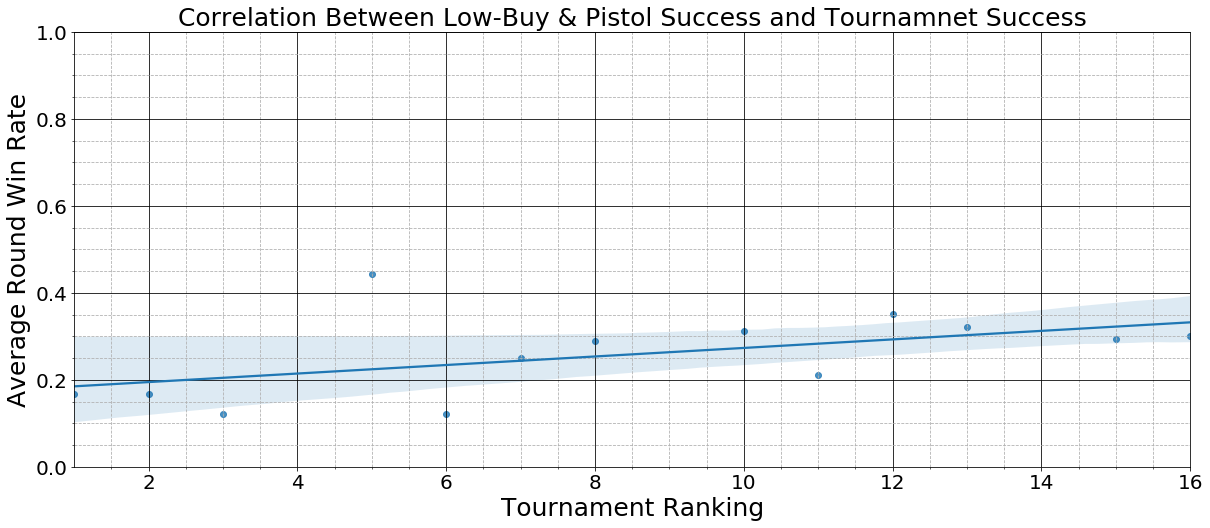

In [31]:
# Plot scatterplot using seaborn
ax = plt.subplots(figsize=(20,8))
ax = sns.regplot(x="Ranking", y="Mean", data=dfKatoLowBuy)

# Add labels and titles
ax.set_title("Correlation Between Low-Buy & Pistol Success and Tournamnet Success", fontsize=25)
ax.set_ylabel("Average Round Win Rate", fontsize = 25)
ax.set_xlabel("Tournament Ranking", fontsize = 25)

# Set axes limits and parameters
ax.set_ylim(0,1)
ax.set_xlim(1,16)
ax.tick_params(labelsize=20)

# Add gridlines
ax.minorticks_on()
ax.grid(which="minor", zorder=-2, linestyle="--")
ax.grid(which="major", color="black", zorder=-1, linestyle="-")

As we can see from the graph above, there seems to be a positive correlation between a team's ability to win these low buy rounds and pistol rounds and their overall success. Cloud9 are an outlier, coming fifth last, but having the highest average success. From looking at the DataFrame, they had terrific success in the pistol rounds and won half of their eco rounds.

In [32]:
dfKatoFullBuy = dfKatoRoundType.unstack(level=-1)
dfKatoFullBuy.columns = dfKatoFullBuy.columns.droplevel()
dfKatoFullBuy = dfKatoFullBuy.drop(["eco", "force", "pistol"], axis=1)
dfKatoFullBuy

Round Type,full
Team,
3DMAX,0.433333
Cloud9,0.500000
Counter Logic Gaming,0.518519
Flipsid3 Tactics,0.157895
Fnatic,0.672956
HellRaisers,0.541667
Keyd Stars,0.500000
LGB eSports,0.441176
Natus Vincere,0.581633


In [33]:
dfKatoFullBuy["full"].mean()

0.5218754927854372

As we can see, Cloud9 were below average in the rounds in which they were fully equipped. Whereas the top 4 teams (Fnatic, Ninjas in Pyjamas, Virtus.pro, and Team EnVyUs) all had higher than average success in these rounds. This tells us that success in the low buy and pistol rounds is helpful, but not putting yourself in those situations by winning the full buy rounds and managing your economy is even better.